# Problem-Algorithm-Solver pattern

* Gen Kuroki
* 2021-07-11, 2022-06-08
* https://discourse.julialang.org/t/function-depending-on-the-global-variable-inside-module/64322/10

A code will be more readable and efficient if the global variables that store the parameters of a problem are passed as arguments to functions _everytime_.

However, many people find it troublesome to pass the parameters as arguments to the function _everytime_.

In order to resolve this misunderstanding, they can try the problem-algorithm-solver pattern explained below.

In order to use the `(; a, b, c) = p` syntax, require VERSION ≥ v"1.7.0-beta" [#39285](https://github.com/JuliaLang/julia/pull/39285).

In [1]:
VERSION ≥ v"1.7.0-beta" #> true

true

`@kwdef` macro is exported as of Julia v1.9.

In [2]:
VERSION ≥ v"1.9.0" #> true

true

## A minimal working example of the problem-algorithm-solver pattern

In [3]:
module FreeFall

"""Problem type"""
@kwdef struct Problem{G, Y0, V0, TS}
    g::G = 9.80665
    y0::Y0 = 0.0
    v0::V0 = 30.0
    tspan::TS = (0.0, 8.0)
end

"""Algorithm types"""
@kwdef struct EulerMethod{T}
    dt::T = 0.1
end
@kwdef struct ExactFormula{T}
    dt::T = 0.1
end
default_algorithm(::Problem) = EulerMethod()

"""Solution type"""
struct Solution{Y, V, T, P<:Problem, A}
    y::Y
    v::V
    t::T
    prob::P
    alg::A
end

"""Solver function"""
solve(prob::Problem) = solve(prob, default_algorithm(prob))

function solve(prob::Problem, alg::ExactFormula)
    (; g, y0, v0, tspan) = prob
    (; dt) = alg
    t0, t1 = tspan
    t = range(t0, t1 + dt/2; step = dt)    
    y(t) = y0 + v0*(t - t0) - g*(t - t0)^2/2
    v(t) = v0 - g*(t - t0)
    Solution(y.(t), v.(t), t, prob, alg)
end

function solve(prob::Problem, alg::EulerMethod)
    (; g, y0, v0, tspan) = prob
    (; dt) = alg
    t0, t1 = tspan
    t = range(t0, t1 + dt/2; step = dt)    
    n = length(t)    
    y = Vector{typeof(y0)}(undef, n)
    v = Vector{typeof(v0)}(undef, n)
    y[1] = y0
    v[1] = v0
    for i in 1:n-1
        v[i+1] = v[i] - g*dt
        y[i+1] = y[i] + v[i]*dt
    end
    Solution(y, v, t, prob, alg)
end

end

Main.FreeFall

This module will calculate the free-fall motion under a uniform gravity potential.

* Problem: The parameters of problems are stored in objects of type `FreeFall.Problem`.

* Algorithm: The parameters of algorithms are stored in objects of types `FreeFall.EulerMethod` and of `FreeFall.ExactFormula`.

* Solver function: The function `FreeFall.solve(prob::FreeFall.Problem, alg)` returns the object of type `FreeFall.Solution` obtained by solving the problem `prob` with the algorithm `alg`.

Note that the `(; a, b, c) = p` syntax of Julia ≥ v1.7, is very useful for extracting the contents of the object that contains parameters. (You can also do the same thing with `@unpack` in the exellent well-known package [Parameters.jl](https://github.com/mauro3/Parameters.jl).)

### Example 1: Compare a numerical solution and an exact one

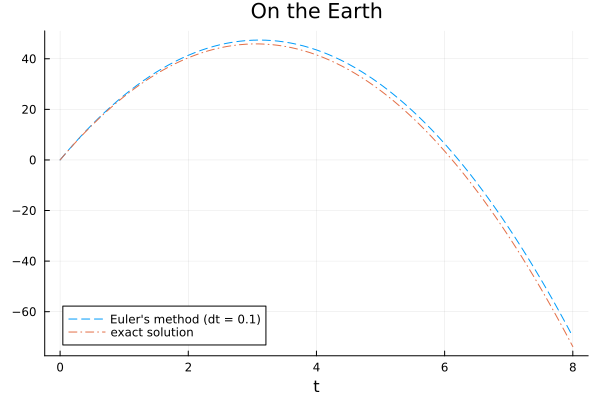

In [4]:
using Plots
default(fmt=:png)

earth = FreeFall.Problem()
sol_euler = FreeFall.solve(earth)
sol_exact = FreeFall.solve(earth, FreeFall.ExactFormula())

plot(sol_euler.t, sol_euler.y; label="Euler's method (dt = $(sol_euler.alg.dt))", ls=:auto)
plot!(sol_exact.t, sol_exact.y; label="exact solution", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft)

Since the time step `dt = 0.1` is not enough small, the error of the Euler method is rather large.

### Example 2: Change the algorithm parameter `dt` smaller

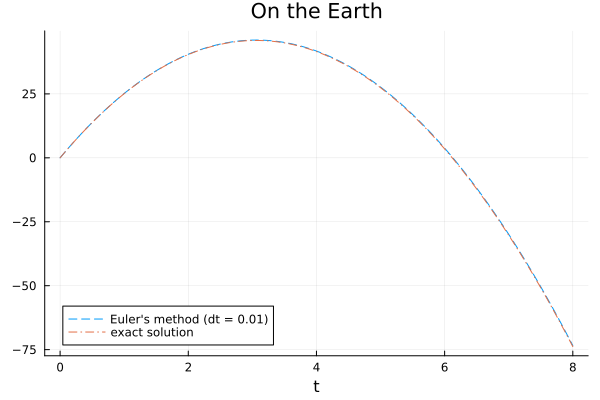

In [5]:
earth = FreeFall.Problem()
sol_euler = FreeFall.solve(earth, FreeFall.EulerMethod(dt = 0.01))
sol_exact = FreeFall.solve(earth, FreeFall.ExactFormula())

plot(sol_euler.t, sol_euler.y; label="Euler's method (dt = $(sol_euler.alg.dt))", ls=:auto)
plot!(sol_exact.t, sol_exact.y; label="exact solution", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft)

### Example 3: Change the problem parameter `g` to the gravitational acceleration on the moon

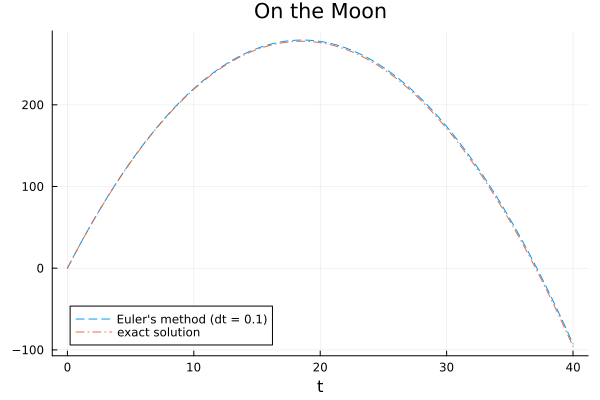

In [6]:
moon = FreeFall.Problem(g = 1.62, tspan = (0.0, 40.0))
sol_euler = FreeFall.solve(moon)
sol_exact = FreeFall.solve(moon, FreeFall.ExactFormula(dt = sol_euler.alg.dt))

plot(sol_euler.t, sol_euler.y; label="Euler's method (dt = $(sol_euler.alg.dt))", ls=:auto)
plot!(sol_exact.t, sol_exact.y; label="exact solution", ls=:auto)
title!("On the Moon"; xlabel="t", legend=:bottomleft)

## Extensibility of the Julia ecosystem

A different author of the `FreeFall` module can define , in the `SomeExtension` module, a new algorithm type and a new method of the `FreeFall.solve` function.  Both a new type and a new method!

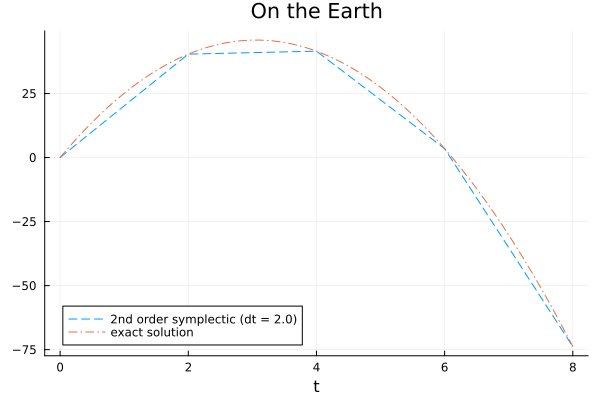

In [7]:
module SomeExtension

using ..FreeFall
using ..FreeFall: Problem, Solution

@kwdef struct Symplectic2ndOrder{T}
    dt::T = 0.1
end

function FreeFall.solve(prob::Problem, alg::Symplectic2ndOrder)
    (; g, y0, v0, tspan) = prob
    (; dt) = alg
    t0, t1 = tspan
    t = range(t0, t1 + dt/2; step = dt)    
    n = length(t)    
    y = Vector{typeof(y0)}(undef, n)
    v = Vector{typeof(v0)}(undef, n)
    y[1] = y0
    v[1] = v0
    for i in 1:n-1
        ytmp = y[i] + v[i]*dt/2
        v[i+1] = v[i] - g*dt
        y[i+1] = ytmp + v[i+1]*dt/2
    end
    Solution(y, v, t, prob, alg)
end

end

earth = FreeFall.Problem()
sol_sympl = FreeFall.solve(earth, SomeExtension.Symplectic2ndOrder(dt = 2.0))
sol_exact = FreeFall.solve(earth, FreeFall.ExactFormula())

plot(sol_sympl.t, sol_sympl.y; label="2nd order symplectic (dt = $(sol_sympl.alg.dt))", ls=:auto)
plot!(sol_exact.t, sol_exact.y; label="exact solution", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft)

The second-order symplectic method gives exact discretizations of the free-fall motions under uniform gravity potentials.

## Composability of the Julia ecosystem

By combining the MonteCarloMeasurements.jl package with the modules given above, we can plot the behavior of the system for perturbations of the initial value.  We did not intend for them to be used in this way!

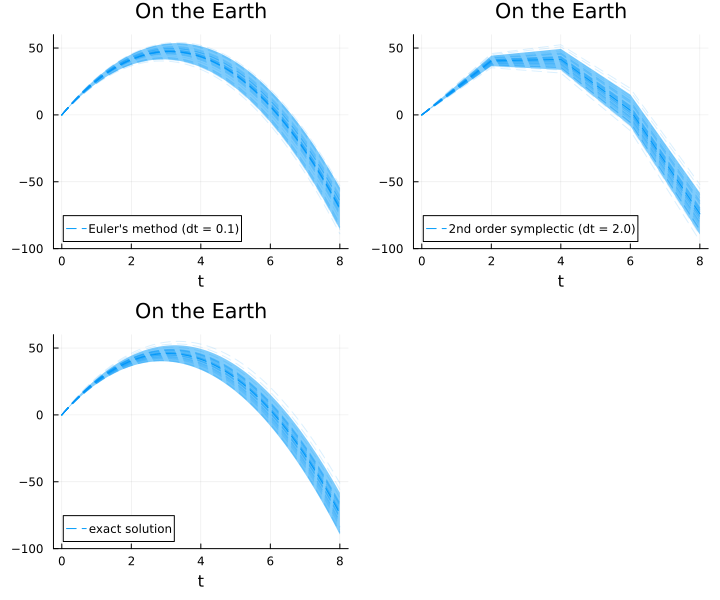

In [8]:
using MonteCarloMeasurements

earth = FreeFall.Problem(y0 = 0.0 ± 0.0, v0 = 30.0 ± 1.0)
sol_euler = FreeFall.solve(earth)
sol_sympl = FreeFall.solve(earth, SomeExtension.Symplectic2ndOrder(dt = 2.0))
sol_exact = FreeFall.solve(earth, FreeFall.ExactFormula())

ylim = (-100, 60)
P = plot(sol_euler.t, sol_euler.y; label="Euler's method (dt = $(sol_euler.alg.dt))", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft, ylim)
Q = plot(sol_sympl.t, sol_sympl.y; label="2nd order symplectic (dt = $(sol_sympl.alg.dt))", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft, ylim)
R = plot(sol_exact.t, sol_exact.y; label="exact solution", ls=:auto)
title!("On the Earth"; xlabel="t", legend=:bottomleft, ylim)
plot(P, Q, R; size=(720, 600))